## import .py files in Google Colab
https://stackoverflow.com/questions/48905127/importing-py-files-in-google-colab

select all the files you need at once

In [1]:
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at drive


In [0]:
import numpy as np
import os
from keras.models import load_model

from my_data import *
from my_model import *
from my_applications import *
from my_gradcam import *

### Global variables

In [0]:
ROOT_PATH = 'drive/My Drive/medical_image_recognition/'
DATASET_NAME = 'chest_xray'
DATASET_PATH = ROOT_PATH + 'datasets/' + DATASET_NAME + '/'
ARRAY_PATH = ROOT_PATH + 'arrays/' + DATASET_NAME + '/'
MODEL_PATH = ROOT_PATH + 'models/' + DATASET_NAME + '/'

HEIGHT, WIDTH, CHANNELS = 224, 224, 3

### Get the data class helper 

In [5]:
dataclass = data_helper(DATASET_NAME,
                        DATASET_PATH,
                        ARRAY_PATH,
                        height=HEIGHT,
                        width=WIDTH,
                        channels=CHANNELS,
                        histogram_equalization=False)

print(dataclass.directories)
print(dataclass.labels)

['test', 'train', 'val']
{'NORMAL': 0, 'PNEUMONIA': 1}


### Load the data

In [6]:
dataclass._get_images_dir('test')

test_x  = dataclass.x['test']
test_y  = dataclass.y['test']

test: getting images from drive/My Drive/medical_image_recognition/arrays/chest_xray/test(224,224,3).h5
Data shape : (624, 224, 224, 3)
Labels shape : (624, 2)
Found 624 images in 4 seconds.


### Show images

In [0]:
#dataclass.show_image('train', 0)

## Load model and predict

In [0]:
from keras import applications
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, InputLayer
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator


import pickle
import numpy as np
from keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

In [0]:
def build_model(image_shape,
                classes,
                num_layers_to_freeze=21,
                base_model_weights_path=None,
                top_model_weights_path=None):
    
    model_name = f'vgg19_{num_layers_to_freeze}'
    
    # build the base model
    if base_model_weights_path is None:
        base_model_weights_path = 'imagenet'
    base_model = applications.vgg19.VGG19(input_shape=image_shape,
                                          weights=base_model_weights_path,
                                          include_top=False)
    print('Load VGG19 as base model')
    
    # load base model weights
    #base_model.load_weights(base_model_weights_path)
    
    # adding classification block on top of base model
    x = Flatten(input_shape=image_shape, name='flatten')(base_model.output)
    #x = Dense(1024, activation='relu', name='fc1')(x)
    #x = Dropout(0.5, name='dropout1')(x)
    x = Dense(256, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(classes, activation='softmax', name='predictions')(x)
    
    # combine both
    model = Model(inputs=base_model.input, outputs=x, name=model_name)
    
    # load top model weights
    #model.load_weights(top_model_weights_path)
    
    # freeze layers
    for i, layer in enumerate(model.layers):
        if i <= num_layers_to_freeze:
            layer.trainable = False
        else:
            layer.trainable = True
            print(f'Layer {i} {layer.name} is trainable')

    # compile model
    loss_type = 'binary_' if classes == 2 else 'categorical_'
    loss_type += 'crossentropy'
    model.compile(loss=loss_type,
                  optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
                  metrics=['accuracy'])
    
    print('Model compiled')
    return model

def build_model_bis(image_shape,
                    classes,
                    num_layers_from_vgg=11):
    

    model_name = f'vgg19_depthwise_{num_layers_from_vgg}'
    
    # build vgg 19 model
    vgg = applications.vgg19.VGG19(input_shape=image_shape,
                                   weights='imagenet',
                                   include_top=False)
    print('Load VGG19 as base model')
    
    # block 4
    x = SeparableConv2D(512, (3, 3),
                        activation='relu',
                        padding='same',
                        name='block4_sepconv1')(vgg.layers[num_layers_from_vgg].output)
    x = BatchNormalization(name='block4_conv1_bn')(x)
    x = SeparableConv2D(512, (3, 3),
                        activation='relu',
                        padding='same',
                        name='block4_sepconv2')(x)
    x = BatchNormalization(name='block4_conv2_bn')(x)
    x = SeparableConv2D(512, (3, 3),
                        activation='relu',
                        padding='same',
                        name='block4_sepconv3')(x)
    x = MaxPooling2D((2, 2), name='block4_pool')(x)
    
    # block 5
    x = SeparableConv2D(512, (3, 3),
                        activation='relu',
                        padding='same',
                        name='block5_sepconv1')(x)
    x = BatchNormalization(name='block5_conv1_bn')(x)
    x = SeparableConv2D(512, (3, 3),
                        activation='relu',
                        padding='same',
                        name='block5_sepconv2')(x)
    x = BatchNormalization(name='block5_conv2_bn')(x)
    x = SeparableConv2D(512, (3, 3),
                        activation='relu',
                        padding='same',
                        name='block5_sepconv3')(x)
    x = MaxPooling2D((2, 2), name='block5_pool')(x)
    
    print('Load blocks 4 and 5')

    # adding classification block on top
    x = Flatten(input_shape=image_shape, name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(classes, activation='softmax', name='predictions')(x)
    
    # combine both
    model = Model(inputs=vgg.input, outputs=x, name=model_name)
    
    # load top model weights
    #model.load_weights(top_model_weights_path)
    
    # freeze layers
    for i, layer in enumerate(model.layers):
        if i <= num_layers_from_vgg:
            layer.trainable = False
        else:
            layer.trainable = True
            print(f'Layer {i} {layer.name} is trainable')

    # compile model
    loss_type = 'binary_' if classes == 2 else 'categorical_'
    loss_type += 'crossentropy'
    model.compile(loss=loss_type,
                  optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
                  metrics=['accuracy'])
    
    print('Model compiled')
    return model

In [9]:
NUM_CLASSES = test_y.shape[1]

model_depthwise = build_model_bis((HEIGHT, WIDTH, CHANNELS), classes=NUM_CLASSES)
model_vgg = build_model((HEIGHT, WIDTH, CHANNELS), classes=NUM_CLASSES)

W0706 15:05:50.045515 139655239972736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0706 15:05:50.086078 139655239972736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0706 15:05:50.094180 139655239972736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0706 15:05:50.136383 139655239972736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



80142336/80134624 [==============================] - 1s 0us/step


W0706 15:05:51.864947 139655239972736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0706 15:05:51.865987 139655239972736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0706 15:05:55.150333 139655239972736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.



Load VGG19 as base model


W0706 15:05:55.679306 139655239972736 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0706 15:05:55.680446 139655239972736 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0706 15:05:55.746166 139655239972736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0706 15:05:55.755211 139655239972736 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.pyth

Load blocks 4 and 5
Layer 12 block4_sepconv1 is trainable
Layer 13 block4_conv1_bn is trainable
Layer 14 block4_sepconv2 is trainable
Layer 15 block4_conv2_bn is trainable
Layer 16 block4_sepconv3 is trainable
Layer 17 block4_pool is trainable
Layer 18 block5_sepconv1 is trainable
Layer 19 block5_conv1_bn is trainable
Layer 20 block5_sepconv2 is trainable
Layer 21 block5_conv2_bn is trainable
Layer 22 block5_sepconv3 is trainable
Layer 23 block5_pool is trainable
Layer 24 flatten is trainable
Layer 25 fc1 is trainable
Layer 26 dropout1 is trainable
Layer 27 fc2 is trainable
Layer 28 dropout2 is trainable
Layer 29 predictions is trainable
Model compiled
Load VGG19 as base model
Layer 22 flatten is trainable
Layer 23 fc2 is trainable
Layer 24 dropout2 is trainable
Layer 25 predictions is trainable
Model compiled


In [0]:
weights_depthwise = MODEL_PATH + 'vgg19_depthwise_11.model'
history_depthwise = MODEL_PATH + 'vgg19_depthwise_11.history'

weights_vgg = MODEL_PATH + 'vgg19_blocks_fc1.model'
history_vgg = MODEL_PATH + 'vgg19_blocks_fc1.history'

model_vgg.load_weights(weights_vgg)
model_depthwise.load_weights(weights_depthwise)

## Check metrics

In [11]:
preds_vgg = np.argmax(model_vgg.predict(test_x), axis=-1)
preds_depthwise = np.argmax(model_depthwise.predict(test_x), axis=-1)

ground_truth = np.argmax(test_y, axis=-1)

differences_vgg = [0 if p == g else 1 for p, g in zip(preds_vgg, ground_truth)]
differences_depthwise = [0 if p == g else 1 for p, g in zip(preds_depthwise, ground_truth)]

print(dict(zip(*np.unique(differences_vgg, return_counts=True))))
print(dict(zip(*np.unique(differences_depthwise, return_counts=True))))

{0: 568, 1: 56}
{0: 573, 1: 51}


              precision    recall  f1-score   support

      NORMAL       0.89      0.87      0.88       234
   PNEUMONIA       0.92      0.94      0.93       390

    accuracy                           0.91       624
   macro avg       0.91      0.90      0.90       624
weighted avg       0.91      0.91      0.91       624

Loading history from drive/My Drive/medical_image_recognition/models/chest_xray/vgg19_blocks_fc1.history


<Figure size 432x288 with 0 Axes>

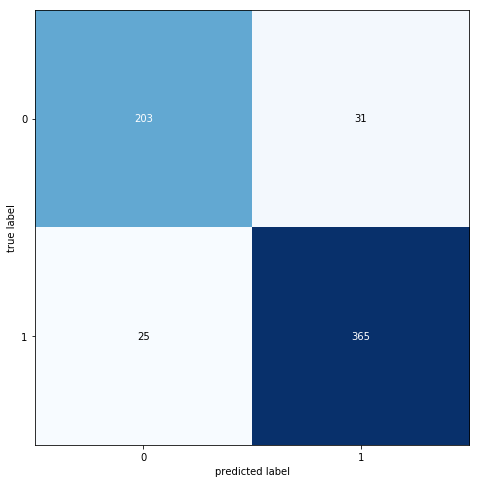

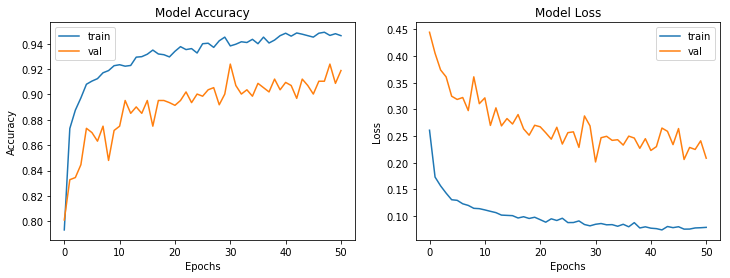

In [12]:
plot_model_performance(preds_vgg, ground_truth, dataclass.labels.keys())
plot_model_history(history_vgg)

              precision    recall  f1-score   support

      NORMAL       0.95      0.82      0.88       234
   PNEUMONIA       0.90      0.97      0.94       390

    accuracy                           0.92       624
   macro avg       0.93      0.90      0.91       624
weighted avg       0.92      0.92      0.92       624

Loading history from drive/My Drive/medical_image_recognition/models/chest_xray/vgg19_depthwise_11.history


<Figure size 432x288 with 0 Axes>

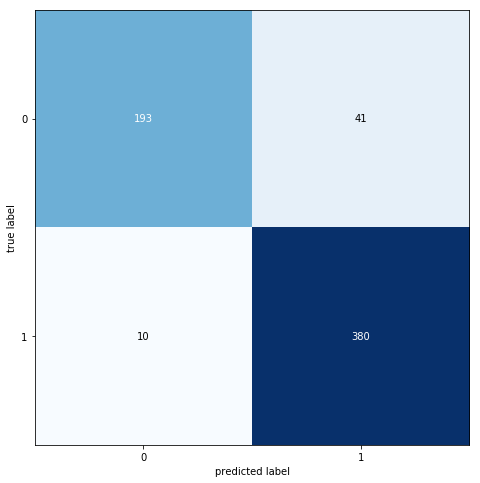

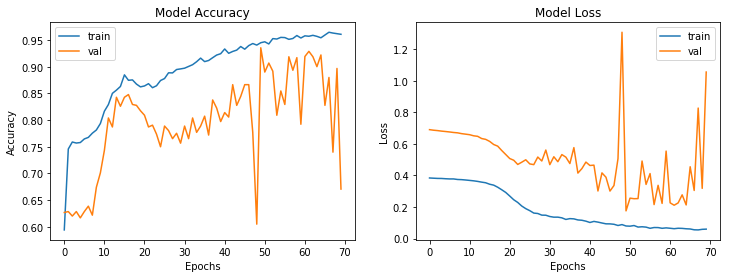

In [13]:
plot_model_performance(preds_depthwise, ground_truth, dataclass.labels.keys())
plot_model_history(history_depthwise)

In [0]:
def get_label_str_from_code(code):
    for label, _code in dataclass.labels.items():
        if code == _code:
            return label

# Grad CAM

## Let's explore our CNN and look at predictions !

In [0]:
guided_model_depthwise = build_guided_model(model_depthwise)
guided_model_vgg = build_guided_model(model_vgg)

VGG 19 GradCAM for layer : block5_pool
Explanation for : PNEUMONIA 0.98
Ground truth is : PNEUMONIA


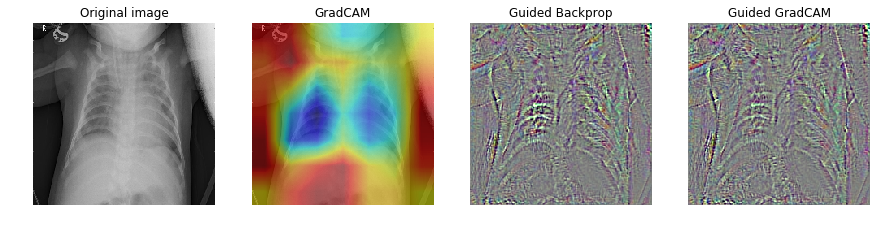

Custom CNN GradCAM for layer : block5_pool
Explanation for : PNEUMONIA 0.99
Ground truth is : PNEUMONIA


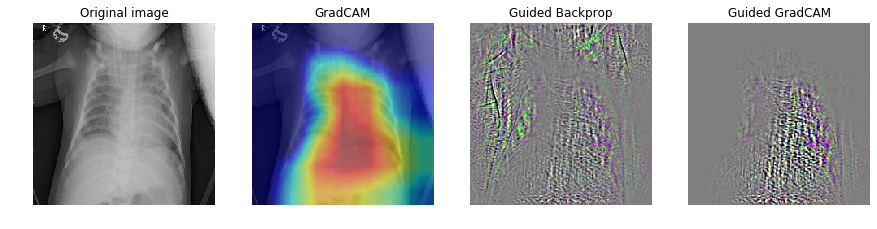

In [16]:
img_index = 432

true_str = get_label_str_from_code(ground_truth[img_index])
img = test_x[img_index]
img_extended = np.expand_dims(img, axis=0)
layer_to_visualize = 'block5_pool'

### VGG 19

pred_str_vgg = get_label_str_from_code(preds_vgg[img_index])
pred_vgg_proba = round(np.max(model_vgg.predict(img_extended)), 2)

print(f'VGG 19 GradCAM for layer : {layer_to_visualize}')
print('Explanation for : {} {:0.2f}'.format(pred_str_vgg, pred_vgg_proba))
print(f'Ground truth is : {true_str}')

x, y , z = compute_saliency_array(model_vgg,
                                   guided_model_vgg,
                                   img,
                                   HEIGHT,
                                   WIDTH,
                                   layer_name=layer_to_visualize,
                                   cls=-1,
                                   visualize=True,
                                   save=False)

### DEPTHWISE
print(f'Custom CNN GradCAM for layer : {layer_to_visualize}')
pred_str_depthwise = get_label_str_from_code(preds_depthwise[img_index])
pred_depthwise_proba = np.max(model_depthwise.predict(img_extended))

print('Explanation for : {} {:0.2f}'.format(pred_str_depthwise, pred_depthwise_proba))
print(f'Ground truth is : {true_str}')

x, y , z = compute_saliency_array(model_depthwise,
                                  guided_model_depthwise,
                                  img,
                                  HEIGHT,
                                  WIDTH,
                                  layer_name=layer_to_visualize,
                                  cls=-1,
                                  visualize=True,
                                  save=False)